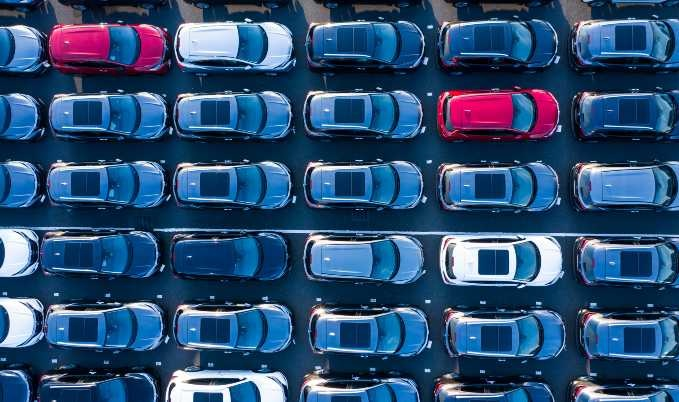


# Прогнозирование стоимости автомобиля

**Цель:** обучить лучшую модель для предсказания цен на автомобили на auto.ru

**Задачи:**

- Собрать тренировочный датасет/парсинг данных
- EDA и визуализация данных
- Поработать над очисткой и обогащением данных
- Оценить важность признаков для модели
- Обучить модель логистической регрессии
- Применить методы машинного обучения для улучшения прогнозирования цены автомобиля
- Настройка гиперпараметров модели
- Стэкинг
- Submission на Kaggle


**Описание датасета:**

Данные - это набор характеристик автомобилей, выставленных на продажу: марка, дата выпуска модели, объем двигателя и т.д. Цена автомобиля является таргетом. Тренировочный датасет сформирован с помощью парсинга данных с сайта Auto.ru. Парсинг осуществлен с учетом признаков, имеющихся в тестовом датасете, всего 34686 наблюдений, и ограничен по году выпуска с 2005 по 2020 и статусами "с пробегом" и "продан". Всего в собранном тренировочном датасете 47423 наблюдений. Необходимо определить лучший алгоритм для предсказания цен на автомобили.


Предсказания цены автомобиля по различным характеристикам относится к задаче регрессии. Но необходимо будет определить лучший алгоритм для предсказания цен на автомобили.

In [ ]:
# импортируем необходимые модули
import numpy as np
import pandas as pd 
from pandas import Series
import seaborn as sns
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import re
# from bs4 import BeautifulSoup    
# import requests
import pandas_profiling
from nltk.util import ngrams
from collections import Counter
import xgboost as xgb

from sklearn.ensemble import BaggingRegressor, StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
# from sklearn.metrics import mean_absolute_percentage_error as mape

from sklearn.preprocessing import (
    LabelEncoder, 
    OneHotEncoder,
    RobustScaler,
    StandardScaler, 
    OrdinalEncoder, 
    Binarizer, 
    PolynomialFeatures
    
)

# import lazypredict 
# from lazypredict.Supervised import LazyRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression
from datetime import timedelta, datetime, date

from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
  
from prettytable import PrettyTable

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42
VAL_SIZE   = 0.33   # 33%
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 2000
LR         = 0.1

# SUBMISSION
VERSION = 6

# Загрузка данных

In [ ]:
# файлы входных данных доступны в "../input/"
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
# загрузим данные
train = pd.read_csv('/kaggle/input/dfcars/df_cars_final.csv')
test = pd.read_csv('/kaggle/input/sf-dst-car-price-prediction/test.csv')
sample_submission = pd.read_csv('/kaggle/input/sf-dst-car-price-prediction/sample_submission.csv')

In [ ]:
# данные предоставлены двумя отдельными датасетами: тренировочный и тестовый.
# посмотрим на данные
train.info(), test.info()

In [ ]:
train.columns, test.columns

# Подготовка данных


переименуем столбцы в датасетах, чтобы они соответствовали друг другу

In [ ]:
def col_change(df_input):
    df_output = df_input.copy()
    df_output = df_output.rename(
        columns={
            'bodyType':'body_type',
            'engineDisplacement':'engine_displacement',
            'enginePower':'engine_power',
            'fuelType':'fuel_type',
            'modelDate':'model_date', 
            'numberOfDoors': 'number_doors', 
            'priceCurrency': 'currency',
            'productionDate': 'production_date', 
            'vehicleConfiguration':'configuration',
            'vehicleTransmission':'transmission', 
            'parsing_unixtime': 'publish_unixtime',
            'Владельцы': 'car_owners',
            'Владение':'ownership',
            'ПТС':'pts',
            'Привод':'drive_type',
            'Руль': 'wheel',
            'Состояние':'condition',
            'Таможня':'customs'
        })
    return df_output

cols_to_drop = [] # список колонок для удаления из датасета

In [ ]:
train = col_change(train)
test = col_change(test)
train.columns, test.columns

# Описание датасета

Используем pandas profiling для оценки датасетов

In [ ]:
pandas_profiling.ProfileReport(train, title="Pandas Profiling Report")

In [ ]:
pandas_profiling.ProfileReport(test, title="Pandas Profiling Report")

Как видно из описаний датасетов при одинаковых полях в некоторых данные отличаются и требуется их очистка.
ПРоведем предобработку отдельно для каждого сета и потом соединим их


## Поля датасета:

- body_type - тип кузова
- brand - марка автомобиля
- car_url - ссылка на автомобиля на сайте авто.ру
- color - цвет автомобиля
- complectation_dict - словарь с данными по комплектации автомобиля
- description - описание автомобиля
- engine_displacement - обдъем двигателя в литрах
- engine_power - мощность двигателя в л.с.
- equipment_dict - словарь с данными по оборудованию автомобиля
- fuel_type - тип топлива (бензин, дизель)
- image - ссылка на фото автомобиля
- mileage - пробег автомобиля в км
- model_date - год начало выпуска модели
- model_info - словарь с информацией по модели
- model_name - наименование модели
- name - наименование автомобиля
- number_doors - количество дверей
- parsing_unixtime - время и дата публикации в формате unixtime
- production_date - год выпуска автомобиля
- sell_id - идентификатор объявления
- super_gen - словарь дополнительной информации, например категория авто - премиум
- configuration - конфигурация автомобиля
- transmission- тип трансмиссии
- vendor - регион выпуска автомобиля
- car_owners - количество владельцев, может быть три значения: 1,2, 3 и более
- ownership - тип владения
- pts - вид ПТС, оригинал или дубликат
- drive_type - тип привода
- wheel - тип руля: правый или левый
- condition - состояние автомобиля
- customs - растаможен автомобиль или нет
- price - цена автомобиля
- currency - валюта стоимости автомобиля

Трейн датасет состоит и 33 признакoв, в том числе целевая переменная 'price', из них 25 признаков в виде строк, а 6 числовые. Задача прогнозирования цены автомобиля по его характеристикам является задачей логистической регрессии. Строковые признаки необходимо преобразовать. Будем преобразовать в списки. В 'ownership', 'complectation_dict', 'equipment_dict' и 'pts' есть пропуски, которые будем заполнять.

Сразу можно удалить столбцы с изображением, обозначением валюты, и ссылкой на авто и др., так как они не будут влиять на прогноз стоимости.


In [ ]:
to_drop = [
    'car_url', 'image', 'currency', 'publish_unixtime', 
    'ownership'
]
for col in to_drop:
    cols_to_drop.append(col)

## Используемые функции

In [ ]:
# функция удаления столбцов
def drop_columns(cols):
    for col in cols:
        train.drop(col, axis=1, inplace=True)
        test.drop(col, axis=1, inplace=True)

# функция, показывающая распределение данных
def column_info(column):
    print('Информация о столбце {}'.format(column))
    print(f'Количество пустых строк: {data[column].isnull().sum()}')
    print('Распределение столбца:', pd.DataFrame(data[column].value_counts()))
    print(data[column].describe())
    if data[column].dtype == 'int64' or data[column].dtype == 'float64':
        median = data[column].median()
        perc25 = data[column].quantile(0.25)
        perc75 = data[column].quantile(0.75)
        IQR = perc75 - perc25
        print(f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75},IQR: {IQR} Границы выбросов: [{perc25 - 1.5*IQR},{perc75 + 1.5*IQR}]')
        data[column].hist(bins = 10, label = 'IQR')
        plt.legend()
    print('\n')

# функция для удаления выбросов
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound

# функция определения класса авто по модели
def model_segment(x):
    if x in model_3:
        return 3 #  премиум класс
    elif x in model_2:
        return 2 # средний класс
    else:
        return 1 # эконом класс

# метрика в виде функции
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


## Обработка и очистка данных
### Обработка признаков

Заполняем пропуски в 'pts' в тесте

In [ ]:
# заполним пропуски наиболее часто встречающимся значением
test['pts'].fillna('Оригинал', inplace=True)

# присвоим числовые значения каждому типу 
# pts_dict = {'Оригинал':1, 'Дубликат':0}
# train.pts = train.pts.replace(to_replace=pts_dict)
# test.pts = test.pts.replace(to_replace=pts_dict)

In [ ]:
# заполним пропуски значением 'other'
test['equipment_dict'] = test['equipment_dict'].fillna("['other']")

# посчитаем количество указанных в описании комплектации машины хар-к
# если в признаке не строка, значит информации о комплектации нет
test['equipment_dict'] = test['equipment_dict'].apply(
    lambda x: len(x[1:-1].split(',')) if type(x == str) else 0)
train['equipment_dict'] = train['equipment_dict'].apply(
    lambda x: len(x[1:-1].split(',')) if type(x == str) else 0)

In [ ]:

# Заполняем пропуски в 'complectation_dict'
# там где указана комплектация ставим 1, если нет -  0
test['complectation_d'] = test['complectation_dict'].notnull()
test['complectation_dict'] = test['complectation_d'].map({False:0, True: 1})

test.drop('complectation_d', axis=1, inplace=True)

train['complectation_d'] = train['complectation_dict'].notnull()
train['complectation_dict'] = train['complectation_d'].map({False:0, True: 1})

train.drop('complectation_d', axis=1, inplace=True)

Обработаем признак 'body_type'

всего 24 уникальных наименования, больше всего седанов.

In [ ]:
#  Train dataset
train['body_type'] = train['body_type'].apply(lambda x: str(x))
def bodytype(row):
    for body_type in ['внедорожник', 'хэтчбек', 'купе-хардтоп', 'седан', 'универсал', 
                      'родстер', 'кабриолет', 'компактвэн', 'лифтбек', 'купе']:
        if row.lower().startswith(body_type):
            return body_type
train['body_type'] = train['body_type'].apply(bodytype)
train['body_type'] = train['body_type'].apply(lambda x: 'купе' if x == 'купе-хардтоп' else x)

# приведем к единому виду
train.body_type = train.body_type.str.lower()

#  test dataset
test['body_type'] = test['body_type'].apply(lambda x: str(x))
def bodytype(row):
    for body_type in ['внедорожник', 'хэтчбек', 'купе-хардтоп', 'седан', 'универсал', 
                      'родстер', 'кабриолет', 'компактвэн', 'лифтбек', 'купе']:
        if row.lower().startswith(body_type):
            return body_type
test['body_type'] = test['body_type'].apply(bodytype)
test['body_type'] = test['body_type'].apply(lambda x: 'купе' if x == 'купе-хардтоп' else x)
test['body_type'] = test['body_type'].str.lower()

#заменим пустые значения неизвестные 
train['body_type'].fillna('unknown', inplace=True)
test['body_type'].fillna('unknown', inplace=True)


Обработаем признак 'brands'

всего 14 уникальных наименования, больше всего BMW.

In [ ]:
print(f'{len(test.brand.value_counts())} уникальных бренда в тесте и {len(train.brand.value_counts())} бренда в трейне')

In [ ]:
# формируем список из марок, как в тесте, остальное обозначим как "other"

car_list = ['BMW', 'VOLKSWAGEN', 'NISSAN', 'MERCEDES', 'TOYOTA',
            'AUDI', 'MITSUBISHI', 'SKODA', 'VOLVO', 'HONDA', 'INFINITI']

train['brand'] = np.where(train['brand'].isin(
    car_list), train['brand'], 'other')

Обработаем признак 'color'

всего 16 уникальных наименования, больше всего черных автомобилей.

In [ ]:
# формируем список из популярных цветов, остальное обозначим как "other"

color_list = ['чёрный', 'белый', 'серый', 'серебристый', 'синий', 'коричневый',
        'красный', 'бежевый']
#  train dataset
train['color'] = np.where(train['color'].isin(
    color_list), train['color'], 'other')

#  test dataset
test['color'] = np.where(test['color'].isin(
    color_list), test['color'], 'other')

#  создадим новый признак - самый популярный цвет -1, остальное - 0
train['pop_color'] = train.color.apply(lambda x: 1 if x in color_list else 0)
test['pop_color'] = test.color.apply(lambda x: 1 if x in color_list else 0)

Обработаем признак 'description'

в данном поле много разных признаков которые можно выделить

In [ ]:
train.description = train.description.apply(lambda x: x.lower())
test.description = test.description.apply(lambda x: x.lower())

# смотрим на самые частые слова в объявлениях
text = ' '.join(test['description'].values)
text_trigrams = [i for i in ngrams(text.split(' '), 5)]
text_trigrams
my_list = Counter(text_trigrams).most_common(50)
my_list[:20]

# for test
test['new'] = test.description.apply(lambda x: 1 if 'нов' in x else 0)
test['full'] = test.description.apply(lambda x: 1 if ('полная' in x) or ('полный' in x)  else 0)
test['bargain'] = test.description.apply(lambda x: 1 if 'торг' in x else 0)
test['dealer'] = test.description.apply(lambda x: 1 if 'дилер' in x else 0)
test['exchange'] = test.description.apply(lambda x: 1 if 'обмен' in x else 0)
test['urgent'] = test.description.apply(lambda x: 1 if 'срочно' in x else 0)
test['discount'] = test.description.apply(lambda x: 1 if 'скидка' in x else 0)
test['extra'] = test.description.apply(lambda x: 1 if 'подарок' in x else 0)
test['tires'] = test.description.apply(lambda x: 1 if ('шины' in x) or ('резина' in x) else 0)
test['rims'] = test.description.apply(lambda x: 1 if 'диск' in x else 0)
test['heating'] = test.description.apply(lambda x: 1 if 'подогрев сидений' in x else 0)
test['service_incl'] = test.description.apply(lambda x: 1 if 'обслуживание' in x else 0)
test['central_lock'] = test.description.apply(lambda x: 1 if 'центральный замок' in x else 0)
test['power_windows'] = test.description.apply(lambda x: 1 if 'электростеклоподъемники' in x else 0)
test['computer'] = test.description.apply(lambda x: 1 if 'бортовой компьютер' in x else 0)
test['airbag'] = test.description.apply(lambda x: 1 if 'подушки безопасности' in x else 0)
test['power_steering'] = test.description.apply(lambda x: 1 if 'усилитель руля' in x else 0)
test['cruise_control '] = test.description.apply(lambda x: 1 if 'круиз-контроль' in x else 0)
test['parking_sensors'] = test.description.apply(lambda x: 1 if 'парктроник' in x else 0)
test['child_car_seat'] = test.description.apply(lambda x: 1 if 'крепления детских автокресел' in x else 0)
test['good'] = test.description.apply(lambda x: 1 if 'хорош' in x else 0)
test['perfect'] = test.description.apply(lambda x: 1 if 'идеальн' in x else 0)
test['very_good'] = test.description.apply(lambda x: 1 if 'отлич' in x else 0)
#  для трейна
train['new'] = train.description.apply(lambda x: 1 if 'нов' in x else 0)
train['full'] = train.description.apply(lambda x: 1 if ('полная' in x) or ('полный' in x)  else 0)
train['bargain'] = train.description.apply(lambda x: 1 if 'торг' in x else 0)
train['dealer'] = train.description.apply(lambda x: 1 if 'дилер' in x else 0)
train['exchange'] = train.description.apply(lambda x: 1 if 'обмен' in x else 0)
train['urgent'] = train.description.apply(lambda x: 1 if 'срочно' in x else 0)
train['discount'] = train.description.apply(lambda x: 1 if 'скидка' in x else 0)
train['extra'] = train.description.apply(lambda x: 1 if 'подарок' in x else 0)
train['tires'] = train.description.apply(lambda x: 1 if ('шины' in x) or ('резина' in x) else 0)
train['rims'] = train.description.apply(lambda x: 1 if 'диск' in x else 0)
train['heating'] = train.description.apply(lambda x: 1 if 'подогрев сидений' in x else 0)
train['service_incl'] = train.description.apply(lambda x: 1 if 'обслуживание' in x else 0)
train['central_lock'] = train.description.apply(lambda x: 1 if 'центральный замок' in x else 0)
train['power_windows'] = train.description.apply(lambda x: 1 if 'электростеклоподъемники' in x else 0)
train['computer'] = train.description.apply(lambda x: 1 if 'бортовой компьютер' in x else 0)
train['airbag'] = train.description.apply(lambda x: 1 if 'подушки безопасности' in x else 0)
train['power_steering'] = train.description.apply(lambda x: 1 if 'усилитель руля' in x else 0)
train['cruise_control '] = train.description.apply(lambda x: 1 if 'круиз-контроль' in x else 0)
train['parking_sensors'] = train.description.apply(lambda x: 1 if 'парктроник' in x else 0)
train['child_car_seat'] = train.description.apply(lambda x: 1 if 'крепления детских автокресел' in x else 0)
train['good'] = train.description.apply(lambda x: 1 if 'хорош' in x else 0)
train['perfect'] = train.description.apply(lambda x: 1 if 'идеальн' in x else 0)
train['very_good'] = train.description.apply(lambda x: 1 if 'отлич' in x else 0)
cols_to_drop.append('description')

In [ ]:
# train['condition'].value_counts()

Обработаем признак 'engine_displacement'

уникальных значений 56, требуется преобразование значений - отсечение наименования LTR, самое частотное значение: 2.0 LTR


In [ ]:
# преобразуем формат значения
train['engine_displacement'] = train['engine_displacement'].apply(lambda x: x[:3])
test['engine_displacement'] = test['engine_displacement'].apply(lambda x: x[:3])

In [ ]:
# среди числовых значений есть LT
len(test[test['engine_displacement'] == ' LT']), len(train[train['engine_displacement'] == ' LT'])

In [ ]:
# заменим LT на наиболее частое 2.0
test['engine_displacement'] = test['engine_displacement'].apply(lambda x: 2.0 if x == ' LT' else x)
train['engine_displacement'] = train['engine_displacement'].apply(lambda x: 2.0 if x == ' LT' else x)

Обработаем признак 'engine_power'

In [ ]:
# преобразуем формат значения
test['engine_power'] = test['engine_power'].apply(lambda x: x[:3])
train['engine_power'] = train['engine_power'].apply(lambda x: x[:3])

In [ ]:
# переведем признаки в цифровые значения
for feature in ['engine_displacement', 'engine_power']:
        train[feature]=train[feature].astype('float').round(1)
        test[feature]=test[feature].astype('float').round(1)

Обработаем признак 'fuel_type'

всего 5 уникальных значений, самый распространенный тип топлива - бензин.


In [ ]:
# присвоим числовые значения каждому типу топлива
#  самым пополярным 1 и 2, и 3 - остальным видам
fuel_type_dict = {'бензин':1, 'дизель':2, 'гибрид':3, 'электро':3, 'газ':3}
test['fuel_type'] = test['fuel_type'].replace(to_replace=fuel_type_dict)
train['fuel_type'] = train['fuel_type'].replace(to_replace=fuel_type_dict)

признак 'name' дублирует ранее рассмотренную информацию об автомобиле: литраж, модель, тип

признак 'configuration' также дублирует информацию, выделенную в отдельные столбцы(тип двигателя, кузова, кол-во дверей и т.д. 
Можно их удалить.



In [ ]:
to_drop = ['name', 'configuration']
for col in to_drop:
    cols_to_drop.append(col)

Обработаем признак 'super_gen'

In [ ]:
#  создаем поле price_segment со всеми возможными значениями из super_gen
pattern1 = "price_segment': '(.*?)'}"

train['price_segment']  = train['super_gen'].apply(lambda x: re.search(pattern1, x).group(1))
# train['price_segment'].value_counts()

# присвоим числовые значения каждому price_segment
price_segment_dict = {'ECONOMY':1, 'MEDIUM':2, 'PREMIUM':3}
train['price_segment'] = train['price_segment'].replace(to_replace=price_segment_dict)

# в поле model_name перезаписываем название модели авто, как в тесте
pattern2 = "{'code':(.*?)', 'name"

train['model_name'] = train['model_info'].apply(lambda x: re.search(pattern2, x).group(1)[2:])
# train.model_name.sample(3)

# создаем список всех моделей для авто премиум класса
model_3 = train[train['price_segment']==3]['model_name'].unique()

# создаем список всех моделей для авто среднего класса
model_2 = train[train['price_segment']==2]['model_name'].unique()

In [ ]:
# проверим разные ли модели в премиум и среднем классах
model_2 == model_3

In [ ]:
# одинаковых моделей нет в списках
# создаем список всех моделей для авто эконом класса
model_1 = train[train['price_segment']==1]['model_name'].unique()

In [ ]:
# проверим разные ли модели в среднем эконом классах
model_2 == model_1

In [ ]:
# для теста создаем поле price_segment по названию модели model_name    
# заполняем тест значениями класса по модели авто   
test['price_segment'] = test.model_name.apply(model_segment)

for col in ['super_gen', 'model_info']:
    cols_to_drop.append(col) 

Обработаем признак 'transmission'

Здесь 4 уникальных значения, самое популярное значение - автоматическая коробка передач

In [ ]:
# присвоим числовые значения каждому типу 
# transmission_dict = {'автоматическая':1, 'механическая':2, 'роботизированная':3, 'вариатор':4}

# train['transmission'] = train['transmission'].replace(to_replace = transmission_dict)
# test['transmission'] = test['transmission'].replace(to_replace = transmission_dict)

Обработаем признак 'vendor'

Имеется 5 уникальных значений, самое частое - EUROPEAN

In [ ]:
# присвоим числовые значения каждому типу 
# vendor_dict = {'EUROPEAN':1, 'JAPANESE':2,'AMERICAN':3, 'CHINESE':4, 'RUSSIAN':5, 'KOREAN':6}
# test.vendor = test.vendor.replace(to_replace=vendor_dict)
# train.vendor = train.vendor.replace(to_replace=vendor_dict)

Обработаем признак 'car_owners'

Здесь 3 уникальных значения, самое распространенное - 3 и более, присвоим соответствующие числовые значения


In [ ]:
# присвоим числовые значения согласно количеству владельцев
test['car_owners'] = test['car_owners'].apply(lambda x: 1 if x == '1\xa0владелец' else 2 if x == '2\xa0владельца' else 3)
train['car_owners'] = train['car_owners'].apply(lambda x: 1 if x == '1\xa0владелец' else 2 if x == '2\xa0владельца' else 3)

 Обработаем признак 'drive_type'

Имеются три типа привода, самый популярный - полный.

In [ ]:
# присвоим числовые значения каждому типу 
# drive_type_dict = {'полный':1, 'передний':2, 'задний':3}
# test.drive_type = test.drive_type.replace(to_replace=drive_type_dict)
# train.drive_type = train.drive_type.replace(to_replace=drive_type_dict)

Обработаем признак 'wheel' Есть машины в датасете с расположением руля справа, но в основном он расположен слева.


In [ ]:
# присвоим числовые значения каждому типу 
# wheel_dict = {'Левый':1, 'Правый':0}
# test.wheel = test.wheel.replace(to_replace=wheel_dict)
# train.wheel = train.wheel.replace(to_replace=wheel_dict)

признак 'condition' Признак абсолютно неинформативен, все автомобили "Не требует ремонта", удалим столбец.

признак 'customs' Все автомобили в датасете имеют статус "Растаможен", также можно удалить этот столбец.

In [ ]:
cols_to_drop.append('condition')
cols_to_drop.append('customs')
cols_to_drop.append('model_name')

sell_id имеет дубликаты в трейне. Удаляем их

In [ ]:
train = train.drop_duplicates(subset=['sell_id'])

# код авто не нужен для ML
cols_to_drop.append('sell_id')

На основе production_date создадим новый признак - возраст авто

In [ ]:
# добавим новый признак - возраст автомобиля
train['car_age'] = 2021 - train['production_date']
test['car_age'] = 2021 - train['production_date']

#заменим пустые значения неизвестные 
train['car_age'].fillna(train['car_age'].mean(), inplace=True)
test['car_age'].fillna(test['car_age'].mean(), inplace=True)

In [ ]:
# коррекция цены в рублях

k = round((72.1/76.2),2) # коэффициент поправки цены, так как тест 2020 года с трейн 2021

train['price'] = train['price']*k

number_doors - Есть один автомобиль без двери, но он в тестовой выборе. удалять не будем

In [ ]:
# train = train.loc[train.number_doors > 0]
# test = test.loc[test.number_doors > 0]

Обработаем признак 'mileage'

In [ ]:
# Лучшая корреляция с price если брать mileage в сетпени 0.5
train['mileage'] = train['mileage']**(0.5)
test['mileage'] = test['mileage']**(0.5)

# Удаляем все лишник признаки
drop_columns(cols_to_drop)

In [ ]:
# Создадим новый признак пробег за год

# test['km_year'] = (test['mileage']/(datetime.now().year-test['production_date'])).round(1)
# train['km_year'] = (train['mileage']/(datetime.now().year-train['production_date'])).round(1)
# train['km_year'].replace([np.inf],42,inplace=True) 

## Анализ целевой переменной - price

Средняя цена автомобиля около 3.6 миллионов рублей, а медианная - около 2.1 миллионов. Большинство автомобилей стоят от 1.5 до 2.7 миллионов рублей.


In [ ]:
train['price'].hist(bins=77)
train.price.describe()

## Объединение данных

In [ ]:
# для корректной обработки признаков объединяем трейн и тест в один датасет.
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

# объединяем данные
data = test.append(train, sort=False).reset_index(drop=True)


print('Размерность финального датасета:', data.shape)
data.head(2)

## Разбивка признаков по типам

In [ ]:
# определим тип признаков датасета

data.nunique()

In [ ]:
# объединим все полученные признаки по категориям
# sample, price исключили из списка

bin_cols = ['pts', 'wheel', 'new', 'full', 'bargain', 'dealer',
       'exchange', 'urgent', 'discount', 'extra', 'tires', 'rims', 'heating',
       'service_incl', 'central_lock', 'power_windows', 'computer', 'airbag',
       'power_steering', 'cruise_control ', 'parking_sensors', 'pop_color',
       'child_car_seat', 'good','perfect','very_good']
cat_cols = [
    'body_type', 'brand', 'color', 'fuel_type', 'transmission', 'vendor',
    'car_owners', 'drive_type','price_segment'
]
num_cols = [
    'engine_displacement', 'engine_power', 'equipment_dict', 'mileage', 'model_date', 
     'number_doors', 'production_date', 'car_age']
# len(bin_cols+cat_cols+num_cols)

In [ ]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

In [ ]:
# посмотрим на количество пропусков
missings = pd.DataFrame(test.isna().sum()).reset_index()
missings.rename(columns={'index': 'Переменная', 0: 'Кол-во NA'}, inplace=True)
missings

## Посмотрим на распределение числовых переменных

In [ ]:
for col in num_cols:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(data[col], kde=False)

In [ ]:
# прологорифмируем признаки и пробуем нормализовать их распределение
# cols_log = ['equipment_dict', 'model_date', 'production_date']
# for i in cols_log:
#     data[i] = np.log(data[i] + 1)
#     plt.figure(figsize=(10,6))
#     sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
#     plt.show()

In [ ]:
# посмотрим на корреляцию признаков между собой
plt.figure(figsize=(8, 5))
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, annot=True, fmt=".2f")

Видно что очено сильно коррелируют между собой engine_displacement  и engine_power, а также model_date и production_date . 

ПО одному из этих признаков удалим. Посмотрим на их значимость.

In [ ]:
# используем дисперсионный анализ для определения значимости числовых признаков
imp_num = pd.Series(f_regression(data[num_cols], data["price"])[0], index=num_cols)
imp_num.sort_values(inplace=True, ascending=False)
imp_num.plot(kind="bar")
plt.title('Значимость числовых признаков')

In [ ]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y=np.log(train.price), x='number_doors', 
                  data=train, color='darkgreen')
g1.set_title("price of doors number", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

In [ ]:
train[['number_doors', 'price']].corr(method='spearman')

По боксплоту видна зависимость цены от количества дверей, хотя они и слабо коррелируют, поэтому этот признак не удаляем.
Удалим model_date и engine_displacement  из датасета.

In [ ]:
# data.drop('model_date', axis=1, inplace=True)
# data.drop('engine_displacement', axis=1, inplace=True)

## Категориальные признаки

In [ ]:
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data[col])

In [ ]:
#  кодируем категориальные признаки
for column in cat_cols:
    data[column] = data[column].astype('category').cat.codes

In [ ]:
# определим значимость категориальных признаков
imp_cat = pd.Series(mutual_info_regression(pd.concat([data[cat_cols]], axis=1),
                                        data['price'], discrete_features =True),
                    index = pd.concat([data[cat_cols]], axis=1).columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.title('Значимость категориальных признаков')

In [ ]:
# корреляция категориальных признаков между собой

corr = round(data[cat_cols].corr(method='spearman'), 1)
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

drive_type и body_type умеренно коррелируют между собой. Оставим все признаки без изменений


## Бинарные признаки

In [ ]:
# посмотрим распределение бинарных признаков
for col in bin_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data[col])
    plt.title(f"Распределение признака {col}")

In [ ]:
# значимость бинарных признаков
imp_bin = Series(mutual_info_regression(data[bin_cols], data['price'],
                                     discrete_features =True), index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')
plt.title('Значимость бинарных признаков')

In [ ]:
# проверяем данные после преобразования
data.head(5)

In [ ]:
# for cols in ['equipment_dict', 'production_date', 'mileage']:
#     data[cols]=data[cols].round(1)

## Подготовка к машинному обучению

In [ ]:
# разделим снова на train и test, т.к. все признаки уже обработаны
train_data = data[data['sample'] == 1].drop(['sample'], axis=1)
test_data = data[data['sample'] == 0].drop(['sample'], axis=1)



# выделим целевую переменную и признаки
X = train_data.drop(['price'], axis=1)
y = train_data['price']


# standard scaler

# X = StandardScaler().fit_transform(X)


# разделим на тренировочные и валидационные выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# прологарифмируем целевую переменную, тренировать модель будем на ней
y_train_log = np.log(y_train)

In [ ]:
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

# Модели

In [ ]:
# функция отображения метрики модели
def print_learn_report(start, y_test, y_pred):
    print('\nВремя выполнения - ', datetime.now() - start)
    print(f"Точность по метрике MAPE:{(mape(y_test, y_pred))*100:0.2f}%")

## Обучение модели линейной регрессии

In [ ]:
start = datetime.now()

# обучим модель
model_LR = LinearRegression().fit(X_train, y_train_log)
# делаем "логарифмированое" предсказание
y_pred_log = model_LR.predict(X_test)
# приводим цену к нужному формату: экспоненциируем
y_pred = np.exp(y_pred_log)

print_learn_report(start, y_test, y_pred)

## RandomForest

Определим лучшие параметры и обучим на них модель

In [ ]:
start = datetime.now()
# model_RF =  RandomForestRegressor()
# model_RF.fit(X_train, np.log(y_train))
# y_pred = np.exp(model_RF.predict(X_test))
# print_learn_report(start, y_test, y_pred)

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

# rfr = RandomForestRegressor(random_state = RANDOM_SEED)
# rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=10, random_state=RANDOM_SEED, n_jobs = -1)
# rf_random.fit(X_train, np.log(y_train))
# rf_random.best_params_

# best_params_: 
# {'n_estimators': 200,
# 'min_samples_split': 5,
# 'min_samples_leaf': 1,
# 'max_features': 'auto',
# 'max_depth': 15,
# 'bootstrap': True}

# best_rfr = rf_random.best_estimator_
best_rfr = RandomForestRegressor(random_state=RANDOM_SEED
                      , n_estimators=200
                      , min_samples_split=5
                      , min_samples_leaf=1
                      , max_features='auto'
                      , max_depth=15
                      , bootstrap=True)

best_rfr.fit(X_train, np.log(y_train))

predict_rfr = np.exp(best_rfr.predict(X_test))
print_learn_report(start, y_test, predict_rfr)

## LightGBM

In [ ]:
start = datetime.now()

# for e,i in enumerate([5, 50, 250, 500, 750, 2000, 3000, 4000, 15000, 30000]):
#     print(i)
#     regr_uquipment = lgb.LGBMRegressor(n_estimators=i)
#     regr_uquipment.fit(X_train,y_train_log)
#     y_pred = np.exp(regr_uquipment.predict(X_test))
#     print_learn_report(start, y_test, y_pred)
    
model_LGBM = lgb.LGBMRegressor(n_estimators=2000)
model_LGBM.fit(X_train, np.log(y_train))

y_pred = np.exp(model_LGBM.predict(X_test))
print_learn_report(start, y_test, y_pred)

## XGBRegressor

In [ ]:
start = datetime.now()

model_XGBR = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=1000)
model_XGBR.fit(X_train, np.log(y_train))

y_pred = np.exp(model_XGBR.predict(X_test))
print_learn_report(start, y_test, y_pred)

## CatboostRegressor

In [ ]:
start = datetime.now()
model_CBR = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model_CBR.fit(X_train, y_train_log,
#          cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )
y_pred = np.exp(model_CBR.predict(X_test)) 
print_learn_report(start, y_test, y_pred)

In [ ]:
model_CBR.save_model('catboost_model_opt.model_CBR')

In [ ]:
start = datetime.now()
# подбираем гиперпараметры для моделей с лучшими показателями
model = CatBoostRegressor(iterations=50,
                          loss_function='MAPE',
                          metric_period=10)
# оптимальные параметры
grid = {
    'learning_rate': [0.1, 0.13, 0.14, 0.15],
    'depth': [10, 11, 12],
    'l2_leaf_reg': [7, 7.5, 8],
    'random_strength': [0.2, 0.3, 0.4]
}

# grid_search_result = model.grid_search(
#     grid, X=X_train, y=np.log(y_train), plot=False, verbose=False, cv=3)

# grid_search_result['params']

# обучаем модель с оптимальными гиперпараметрами
optimal_parameters = {
    'depth': 12,
    'l2_leaf_reg': 8,
    'random_strength': 0.2,
    'learning_rate': 0.15
}

model_opt = CatBoostRegressor().set_params(**optimal_parameters)
model_opt.fit(X_train, np.log(y_train), verbose=False)

y_pred = np.exp(model_opt.predict(X_test))

print_learn_report(start, y_test, y_pred)

Подбор параметров не дал значительного улучшения и лучшие показатели так и остались у CatBoost модели.

## Бэггинг
### Со случайным лесом

In [ ]:
start = datetime.now()

bagg_rfr = BaggingRegressor(best_rfr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_rfr.fit(X_train, np.log(y_train))
predict_bagg_rfr = np.exp(bagg_rfr.predict(X_test))
print_learn_report(start, y_test, predict_bagg_rfr)

C LightGBM

In [ ]:
start = datetime.now()

bagg_LGBM = BaggingRegressor(model_LGBM, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_LGBM.fit(X_train, np.log(y_train))
predict_bagg_rfr = np.exp(bagg_LGBM.predict(X_test))
print_learn_report(start, y_test, predict_bagg_rfr)

С XGB

In [ ]:
start = datetime.now()

bagg_XGB = BaggingRegressor(model_XGBR, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_XGB.fit(X_train, np.log(y_train))
predict_bagg_xgb = np.exp(bagg_XGB.predict(X_test))
print_learn_report(start, y_test, predict_bagg_xgb)

В результате применения бэггинга результаты для LightGBM улучшились, а для Random Forest Regressor и XGB Regressor снизились.

## Стеккинг. Ансамбли моделей

In [ ]:
start = datetime.now()

estimators=[('lgbm', lgb.LGBMRegressor(n_estimators=2000
                                        ,random_state=RANDOM_SEED))
            ,('xgb', xgb.XGBRegressor(objective='reg:squarederror'
                                      ,colsample_bytree=0.5
                                      ,learning_rate=0.05
                                      ,max_depth=12
                                      ,alpha=1
                                      ,n_estimators=1000))]

st_ensemble = StackingRegressor(estimators=estimators
                                ,final_estimator = CatBoostRegressor(iterations = 2000
                                                                     ,random_seed = RANDOM_SEED
                                                                     ,eval_metric='MAPE'
                                                                     ,custom_metric=['R2', 'MAE']
                                                                     ,silent=True
                                                                     ,learning_rate=0.15
                                                                     ,depth=12
                                                                     ,l2_leaf_reg=8
                                                                     ,random_strength=0.2))

    
st_ensemble.fit(X_train, np.log(y_train))

predict_ensemble = np.exp(st_ensemble.predict(X_test))
print_learn_report(start, y_test, predict_ensemble)

## Submission

In [ ]:
predict_submission = np.exp(model_CBR.predict(X_sub))
predict_submission

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

## Выводы:

Данные - это набор характеристик автомобилей, выставленных на продажу: марка, тип кузова, дата выпуска модели, объем двигателя и т.д. Цена автомобиля является целевой переменной. Тренировочный датасет сформирован с помощью парсинга данных с сайта Auto.ru. Парсинг осуществлен с учетом признаков, имеющихся в тестовом датасете, всего 34686 наблюдений, и ограничен по году выпуска с 2005 по 2020 и статусом "с пробегом", в нем отсутствуют машины с флагом "продан". Всего в собранном тренировочном датасете 47423 наблюдений. Необходимо определить лучший алгоритм для предсказания цен на автомобили, это задача логистической регрессии.

Обрабатываем тестовый датасет и подгоняем под него тренировочный, чтобы они соответствовали
Чтобы категории кузова совпадали в трейне и тесте, выберем типы кузова, которые есть в тестовом датасете
Мы отобрали цвета с наибольшим количеством значений, остальные причислим к категории другое. Также выделен признак -  популярный цвет. Черные автомобили чаще всего оказываются самыми дорогими.
В тестовом датасете меньше марок, чем в тренировочном, поэтому сформируем список  из тех марок, что указаны в тесте, остальные отнесем к категории – другое.

Целевая переменная перекошена, поэтому ее прологарифмируем, его и будем предсказывать, чтобы распрделение было более нормальным, это влияет на качество предсказаний регрессии.
Признаки содержат выбросы, удаляем только самые явные.

В столбце sell_id в тренировочной выборке есть дубликаты, мы их удалили.
Добавлен признак - возраст автомобиля.

Большинство автомобилей в тренировочной выборке имеют возраст  3 - 10 лет,средний возраст автомобиля - примерно 7.5 лет, чем старше автомобиль, тем он дешевле.

Чем больше пробег, тем ниже цена на авто. Средний пробег - приблизительно 100 км.
Есть зависимость между объемом двигателя и ценой автомобиля: чем больше объем, тем, в среднем, выше цена.
Большинство автомобилей имеют мощность двигателя от 150 до 300 л.с.,чем мощнее двигатель, тем, в среднем, выше цена.
Если информация о комплектации отсутствует, мы заполняли  пропуски нулями.

Дополнительные характеристики из описания мы вычленили, проанализировав самые популярные, из них сделали дополнительные признаки.

Автомобили с автоматической коробкой передач стоят дороже, а с механической - дешевле.
Автомобили с задним приводом стоят дороже, а с передним - дешевле.
Существуют метки премиум класса напротив MERCEDES и BMW, отразили это добавив признак класса автомобиля.
Мы провели многочисленные проверки работы моделей, в том числе с подобранными гиперпараметрами, пытались использовать бэггинг и стеккинг.

Кроме того, пытались учитывать экономические показатели. Так как тестовый датасет создавался в 2020 году
а новый датасет 2021, цену в трейне умножили на отношение среднего курса рубля в 2020 к сегодняшнему курсу.

На основе пробега авто создавали новый признак пробег авто в год по возрасту авто - km_year. Этот признак также не улучшил показатели.

Стеккинг использовали только для лучших моделей, так как метод требует много времени для обработки.
Лучший результат показала оптимизированная модель CatboostRegressor.
Мы считаем, что при сабмите нужно учитывать изменение рынка и ценообразования за последний год, минимум 10%
Финальный результат метрики MAPE на лучшей модели - 10.89%

## What's next?
Что еще можно сделать, чтобы улучшить результат:

- Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
- Попробовать другие алгоритмы и библиотеки ML
- Сгенерировать новые признаки
- Подгрузить еще больше данных
- Использование Blending & Stacking не принесло ожидаемого улучшения качества предсказаний. Наилучший результат имело применение Random Forest с регуляризацией.
